# Картины по номерам
## Старт здесь
### Ткни на эту ячейку, и нажимай Shift-Enter для предвижения вниз

### Импортируем библиотеки

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import PIL as P
import sklearn as S
import os
from sklearn import cluster
from collections import defaultdict
import numpy as np
import math
from PIL import Image, ImageDraw, ImageFilter, ImageFont
def imopen(filename):
    return P.Image.open(filename)
def draw(im):
    return P.ImageDraw.Draw(im)
def pixel(im):
    return im.load()
import datetime

### Создаём необходимые функции для кластеризации на картинке

In [18]:
def to_numpy(im, use_coords=False):
    d = pixel(im)
    w, h = im.size
    a = np.zeros((w*h, 5 if (use_coords>0) else 3))
    for k in range(3):
        for i in range(w):
            for j in range(h):
                a[j*w + i, k] = d[i, j][k]
    if use_coords > 0:
        for i in range(w):
            for j in range(h):
                a[j*w + i, 3] = i*use_coords
                a[j*w + i, 4] = j*use_coords
    return a, w, h

def reduce_sizeN(im, wmax, hmax):
    if wmax <=0 or hmax <=0:
        print("Invalid wmax or hmax")
        return
    n = 1
    while im.size[0]//n > wmax:
        n += 1
    while im.size[1]//n > hmax:
        n += 1
    return im.resize((im.size[0]//n, im.size[1]//n))

def reduce_size(im, wmax, hmax):
    if wmax <=0 or hmax <=0:
        print("Invalid wmax or hmax")
        return
    kfact = min(1., wmax/im.size[0], hmax/im.size[1])
    return im.resize((int(im.size[0]*kfact), int(im.size[1]*kfact)))

def from_numpy(a, w, h):
    im = P.Image.new("RGB", (w, h))
    d = draw(im)
    for i in range(w):
        for j in range(h):
            d.point(tuple([i, j]), tuple(int(a[j*w + i, k]) for k in range(3)))
    return im

def arr_from_labels(cls, lbl):
    n = np.zeros((len(lbl), cls.shape[1]))
    for j in range(cls.shape[1]):
        for i, v in enumerate(lbl):
            n[i, j] = cls[v, j]
    return n

def kmeans_cluster(n_clusters=16, n_jobs=8, max_iter=300):
    km = S.cluster.KMeans(n_clusters=n_clusters, n_jobs=n_jobs, max_iter=max_iter, algorithm="elkan", copy_x=True)
    def res(n):
        km.fit(n)
        return km.cluster_centers_, km.labels_
    return res

def mini_kmeans_cluster(n_clusters=16, max_iter=300, bs=500):
    km = S.cluster.MiniBatchKMeans(n_clusters=n_clusters, batch_size=bs, max_iter=max_iter)
    def res(n):
        km.fit(n)
        return km.cluster_centers_, km.labels_
    return res

def meanshift_cluster(n_jobs=6):
    ms = S.cluster.MeanShift(n_jobs=n_jobs)
    def res(n):
        ms.fit(n)
        return ms.cluster_centers_, ms.labels_
    return res

def recursive_do(cluster, level=3):
    def res(n, l = level):
        try:
            cs, lb = cluster(n)
        except Exception as e:
            print("Exception: ", e)
            return n
        if l == 0:
            return arr_from_labels(cs, lb)
        n = np.array(n, copy=True)
        for i, v in enumerate(cs):
            idx = (lb==i)
            nn = res(n[idx, :], l - 1)
            try:
                n[idx, :] = nn
            except Exception as e:
                print(f"n: {n.shape}, nn: {nn.shape}")
        return n
    return res

def make_pic(im, cluster, rlevel=0, use_coords = 0, prefit= lambda x: x, prefit_rev= lambda x: x):
    start = datetime.datetime.now()
    n, w, h = to_numpy(im, use_coords=use_coords)
    print(f"[{datetime.datetime.now()-start}] Изображение конвертировано в числовой массив пикселей")
    nn = recursive_do(cluster, level=rlevel)(prefit(n))
    print(f"[{datetime.datetime.now()-start}] Пиксели кластеризованы")
    return from_numpy(prefit_rev(nn), w, h)

def get_colormap(im):
    return np.unique(to_numpy(im)[0], axis=0)

def enlarge(im, factor=2):
    return im.resize((int(im.size[0]*factor), int(im.size[1]*factor)))

def cadre(im, cluster, max_rlevel, use_coords=1.2):
    for i in range(max_rlevel):
        display(make_pic(im, cluster=cluster, rlevel=i, use_coords=use_coords))

### Создаём функции, необходимые для создания контурного рисунка

In [47]:
def get_contour(im):
    return im.convert("L").filter(ImageFilter.CONTOUR)

def get_contour2(im):
    return im.convert("L").filter(ImageFilter.FIND_EDGES)

def normalize(tpl):
    ln2 = tpl[0]*tpl[0] + tpl[1]*tpl[1] + tpl[2]*tpl[2]
    if ln2 > 0:
        ln = 1/math.sqrt(ln2)
        return (tpl[0]*ln, tpl[1]*ln, tpl[2]*ln)
    else: return (0, 0, 0)

def order_color(x):
    return 9000*x[2] + 30*x[1] + x[0]

def mark_contour(im, cont_im, grid_size=30, lim=15, font_size=10):
    fnt = ImageFont.truetype('./font2.ttf', font_size)
    im_new = cont_im.copy()
    d = ImageDraw.Draw(im_new)
    p = im.load()
    cont_p = cont_im.load()
    colors = defaultdict(int)
    numbers = []
    coords = []
    for i in range(grid_size - 1, im.size[0], grid_size):
        last = 0
        for j in range(im.size[1]):
            if cont_p[i, j] < 255:
                if j - last >= lim:
                    ypos = (j + last)//2
                    coords.append((i, ypos))
                    color = tuple(p[i, ypos])
                    numbers.append(color)
                    colors[color] += 1
                last = j
    color_map = list(sorted(colors.keys(), key=lambda x: normalize(x)))
    for i, v in enumerate(color_map):
        colors[v] = i + 1
    for i, v in enumerate(coords):
        msg = str(colors[numbers[i]])
        w, h = d.textsize(msg)
        d.text((v[0] - w//2, v[1] - h//2), msg, font=fnt, fill="black")
    palette = Image.new('RGB', (len(color_map), 2), (255, 255, 255))
    pl_dr = ImageDraw.Draw(palette)
    for i, v in enumerate(color_map):
        pl_dr.point((i, 1), v)
    factor=im.size[0]/len(color_map)
    palette = enlarge(palette, factor=factor)
    pl_dr = ImageDraw.Draw(palette)
    fnt = ImageFont.truetype('./font.ttf', font_size*2)
    for i, v in enumerate(color_map):
        msg = str(i + 1)
        w, h = d.textsize(msg)
        pl_dr.text(((i+0.5)*factor - w//2, factor//2-h//2), msg, font=fnt, fill="black")
    return im_new, palette

### Настраиваем папку и картинку, с которой будем работать (SOURCE: изменить путь на нужный)

In [36]:
SOURCE = "/home/aynur/Downloads/A1.jpeg"
NUM = 0

BASEDIR = SOURCE.rsplit(".", 1)[0]
suff = 1
while os.path.exists(BASEDIR):
    BASEDIR = BASEDIR.rsplit("--", 1)[0] + "--" + str(suff)
    suff += 1
os.mkdir(BASEDIR)
def fname():
    global NUM
    NUM += 1
    nm = BASEDIR + "/" + str(NUM) + ".png"
    print(f"Filename: {nm}")
    return nm

### Загружаем картинку, производим размытие для удаления мелких деталей и бликов (увеличить radius для большего размытия)

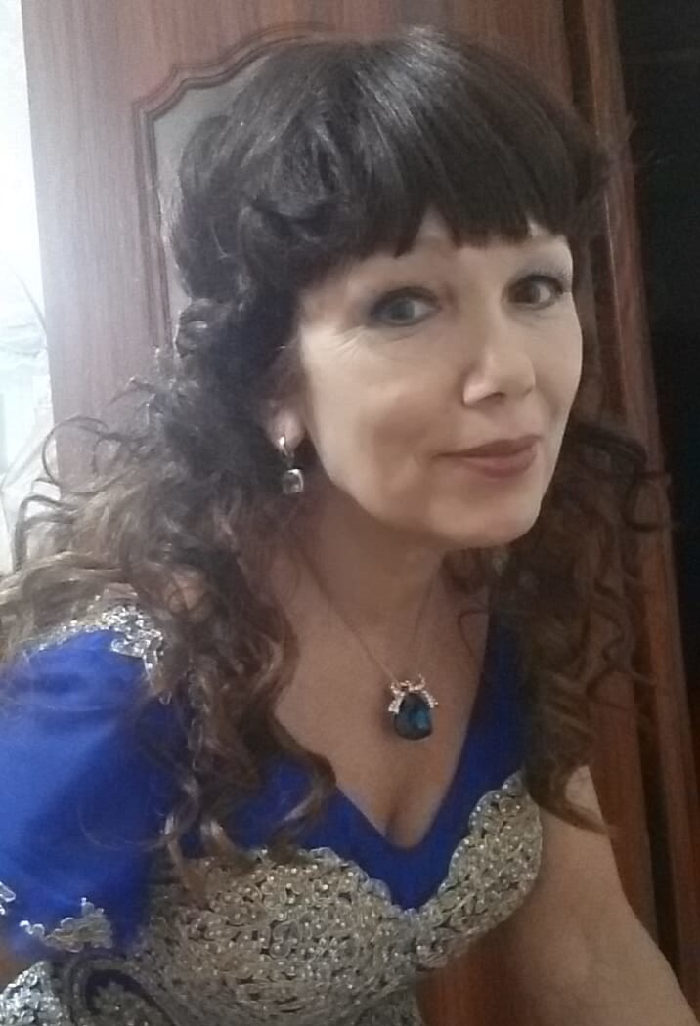

Количество цветов: 91784
Filename: /home/aynur/Downloads/A1--4/5.png


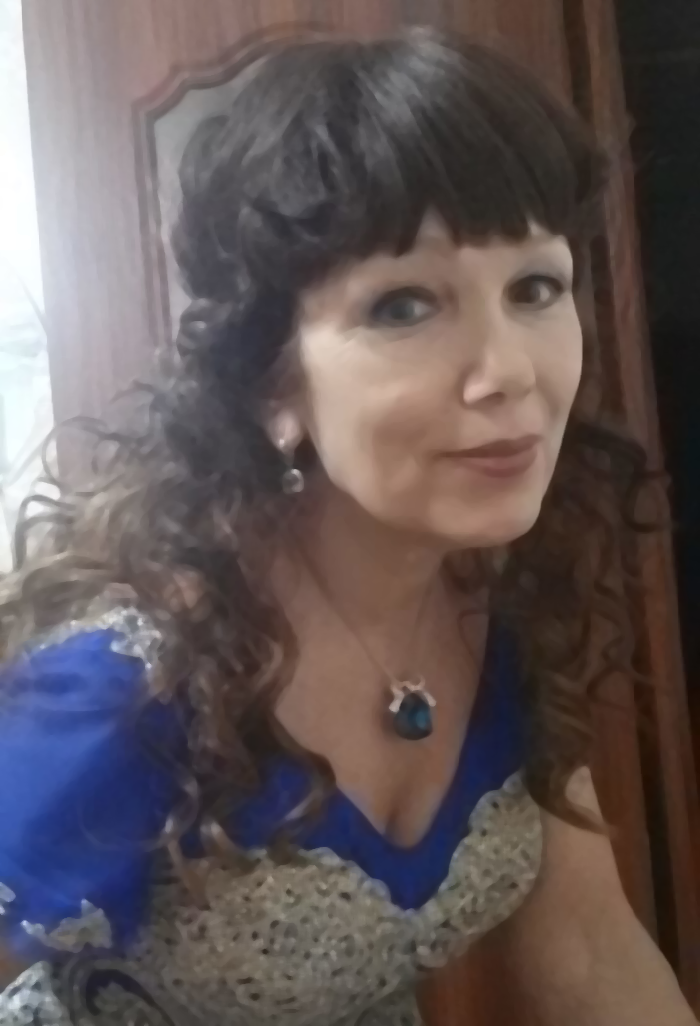

In [42]:
im = imopen(SOURCE)
im = reduce_size(im, 700, 1200)
display(im)
im = im.filter(ImageFilter.MedianFilter(size=7))
print("Количество цветов:",  get_colormap(im).shape[0])
im.save(fname())
im

### Кластеризуем картинку по цветам (и немного по координате: попробовать поменять use_coords). 
#### Для более мелкой детализации увеличиваем n_clusters(количество частей разбиения) и rlevel(уровень разбиения)
### Создаём контурный рисунок

[0:00:00.845504] Изображение конвертировано в числовой массив пикселей
[0:00:05.936607] Пиксели кластеризованы
Filename: /home/aynur/Downloads/A1--4/6.png
Количество цветов: 342


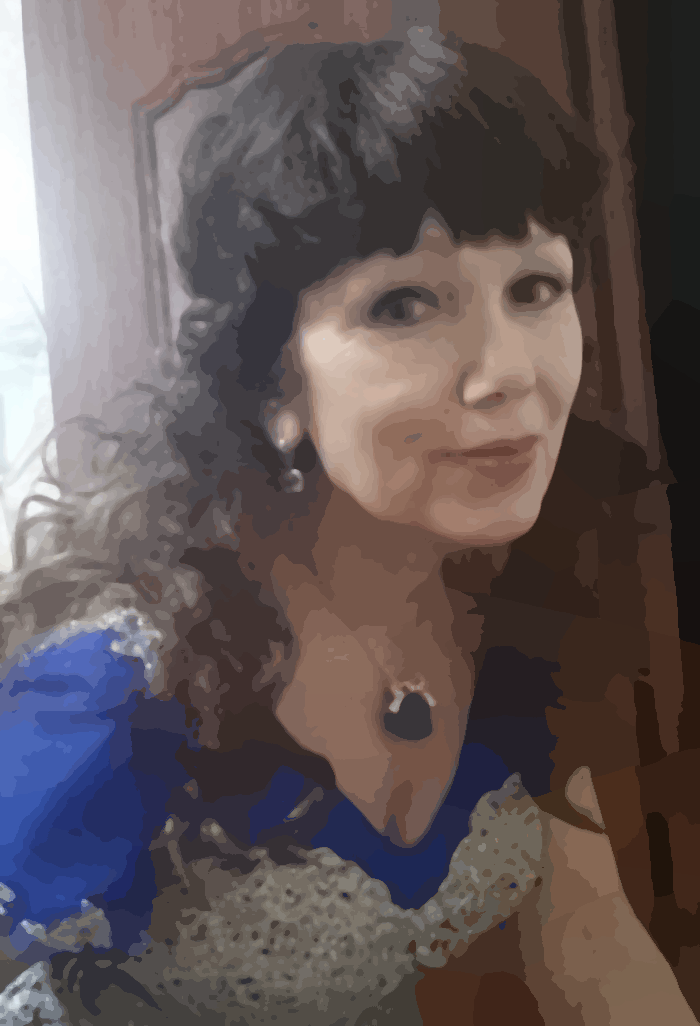

Filename: /home/aynur/Downloads/A1--4/7.png


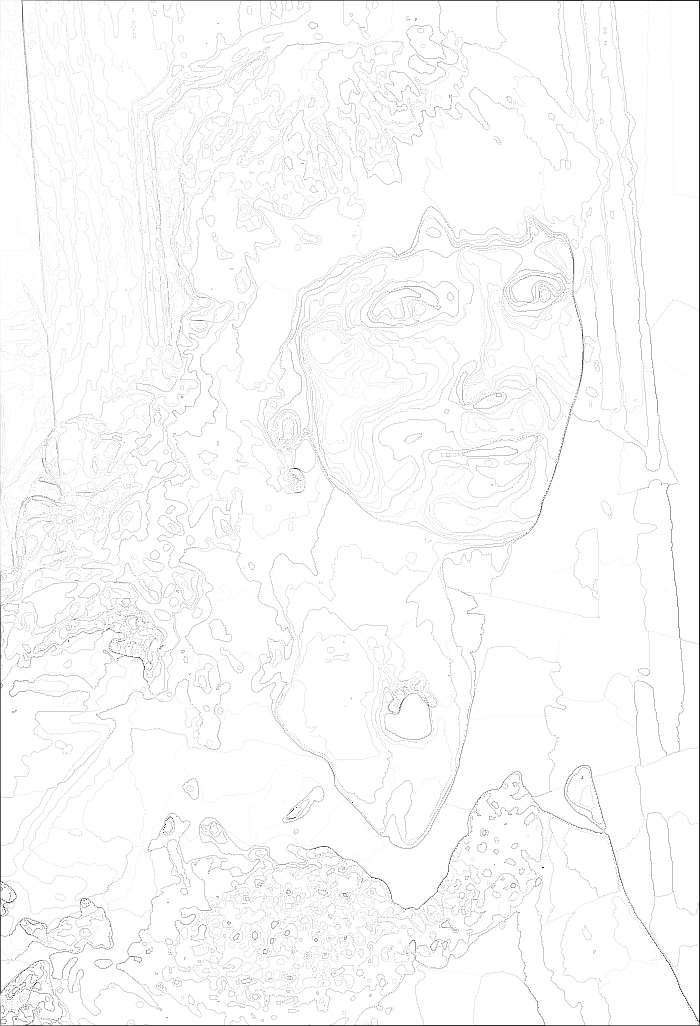

In [43]:
pic = make_pic(im, cluster=mini_kmeans_cluster(n_clusters=7, max_iter=30), rlevel=2, use_coords=0.2, prefit=lambda x: x*x, prefit_rev=lambda x: np.sqrt(x))
pic.save(fname())
print("Количество цветов:", get_colormap(pic).shape[0])
display(pic)
cont_pic = get_contour(pic)
cont_pic.save(fname())
cont_pic

### Уменьшаем количество цветов. Для этого кластеризуем полученное изображение строго по цвету, ограничивая количество кластеров

[0:00:00.607589] Изображение конвертировано в числовой массив пикселей
[0:00:28.586456] Пиксели кластеризованы
Filename: /home/aynur/Downloads/A1--4/17.png
Количество цветов: 25


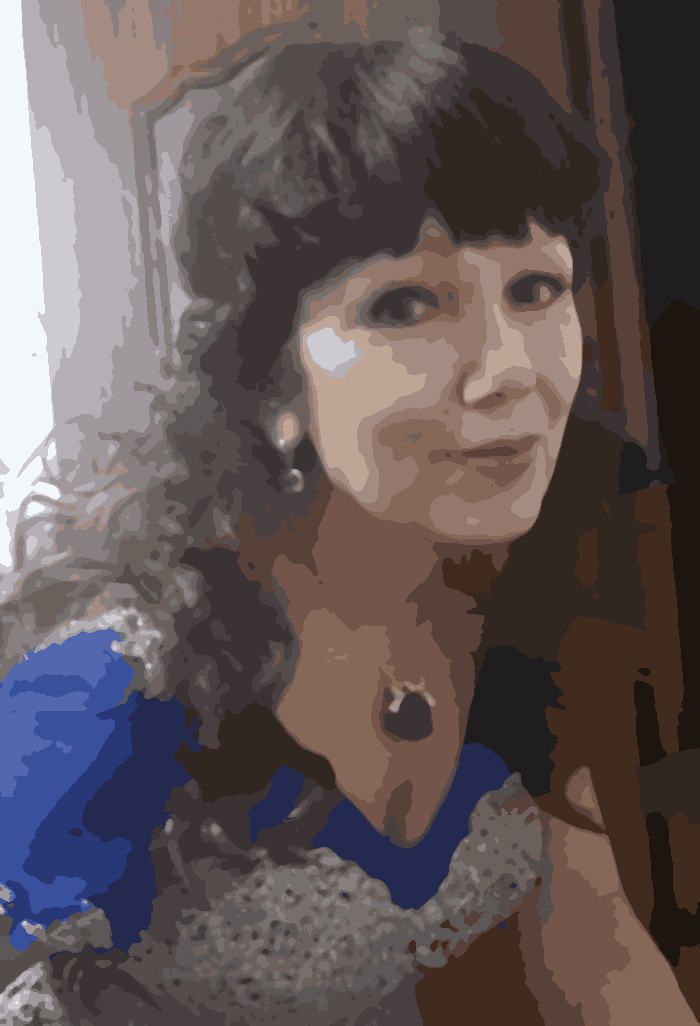

Filename: /home/aynur/Downloads/A1--4/18.png


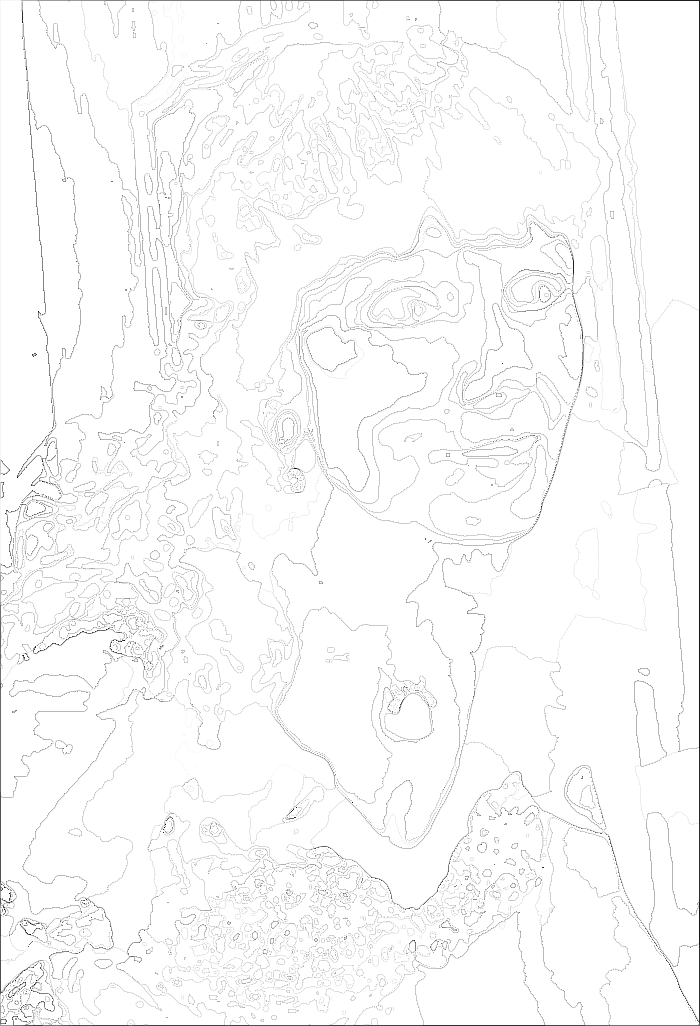

In [50]:
u = make_pic(pic, cluster=kmeans_cluster(n_clusters=25, max_iter=300), rlevel=0, use_coords=0)
u.save(fname())
print("Количество цветов:", get_colormap(u).shape[0])
display(u)
cont_u = get_contour(u)
cont_u.save(fname())
cont_u

### Увеличиваем полученные картинки для того, чтобы цифры хорошо уместились

Filename: /home/aynur/Downloads/A1--4/19.png


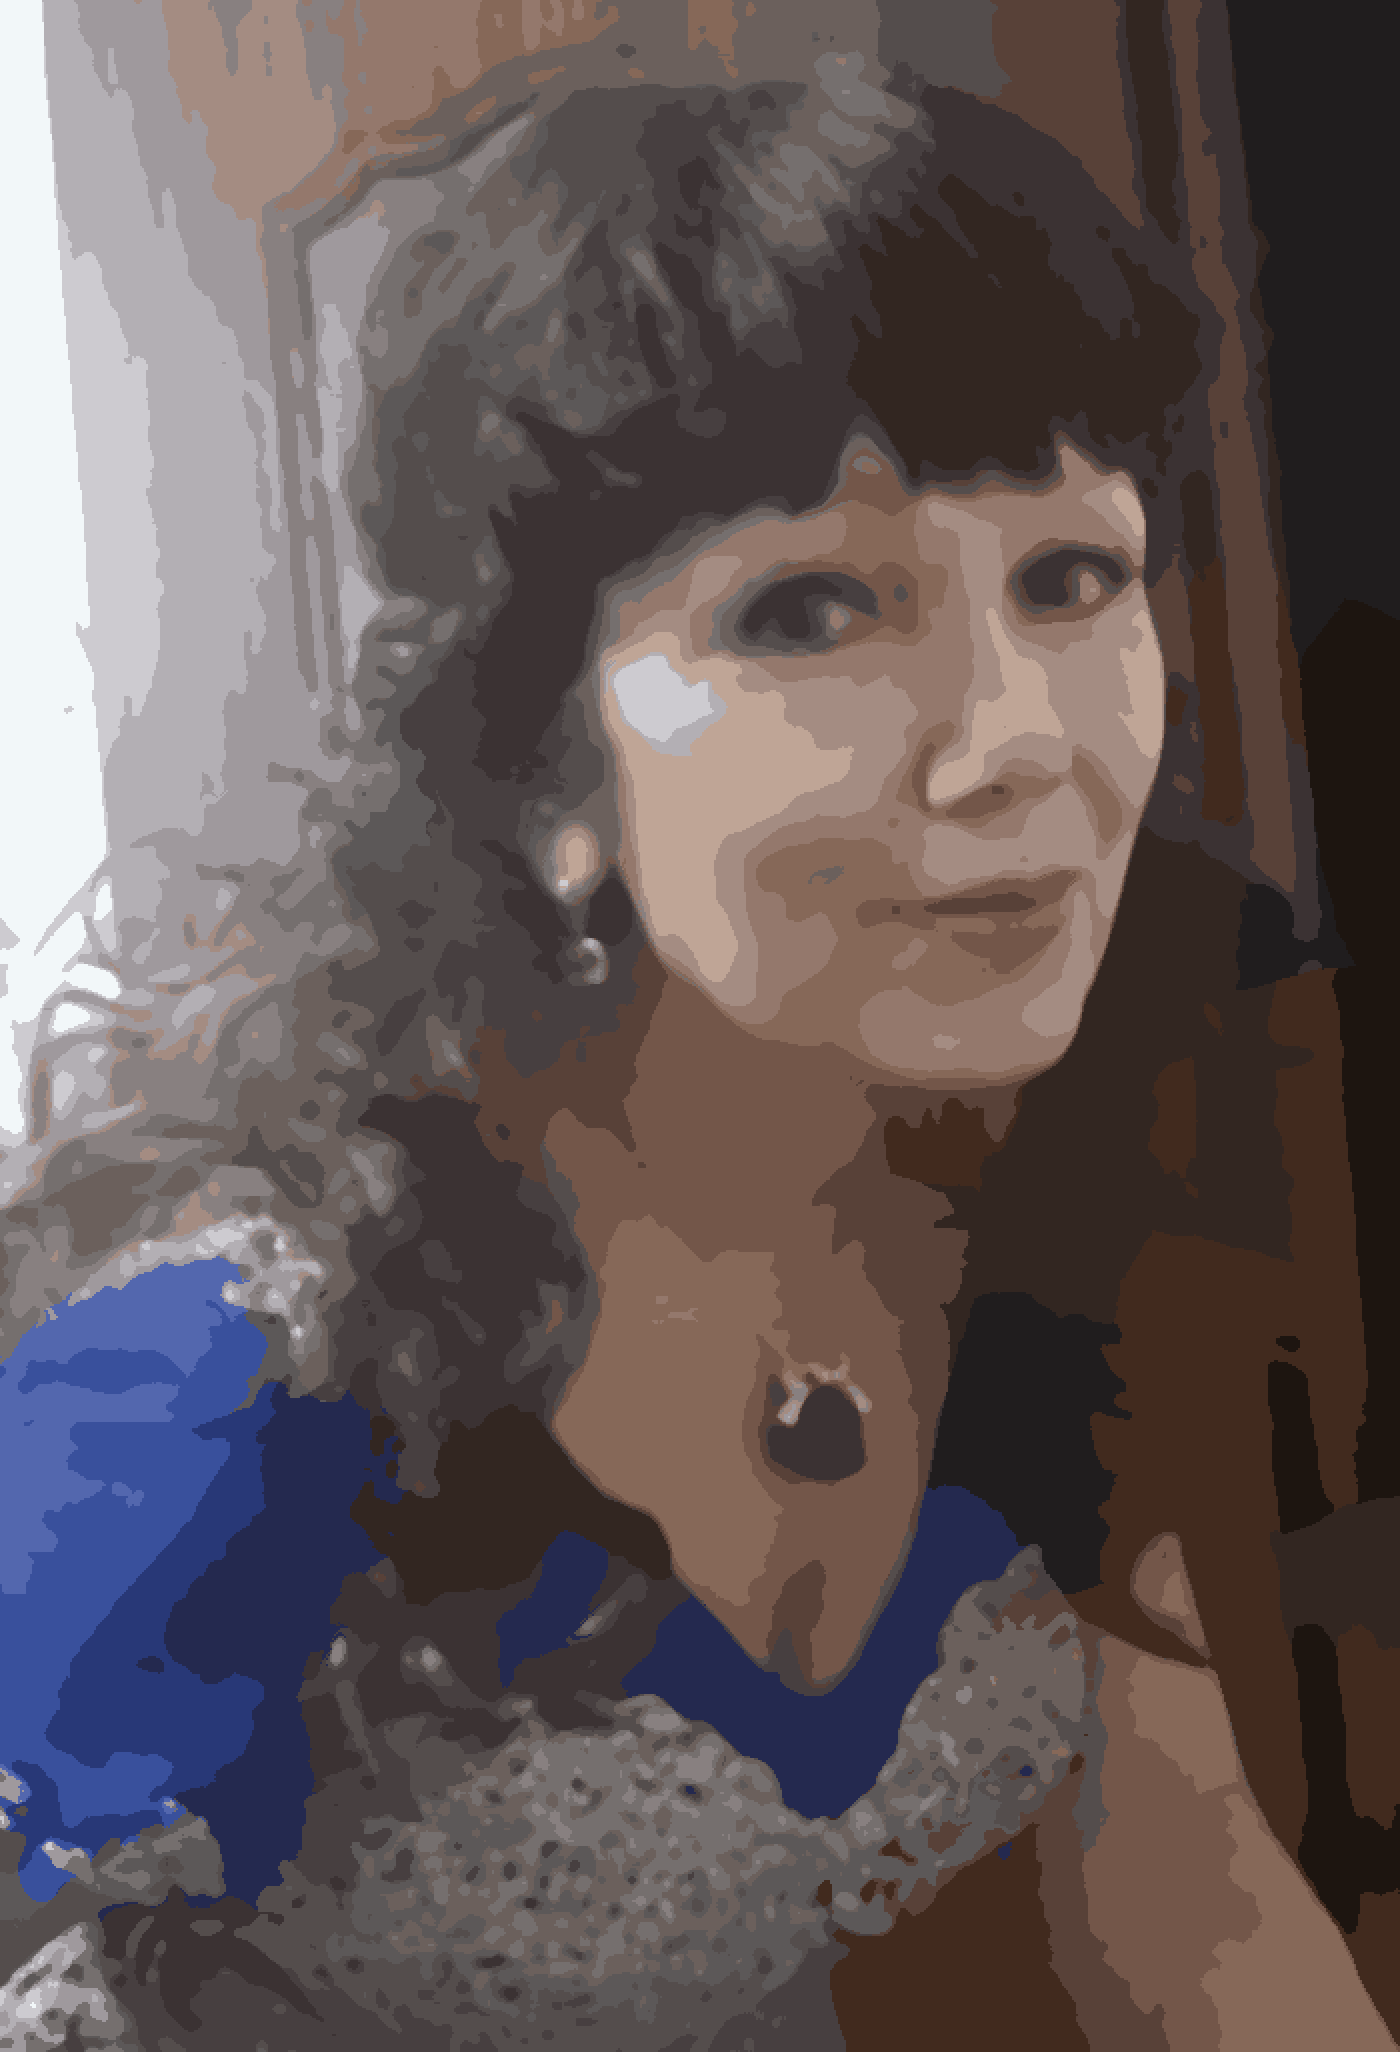

Filename: /home/aynur/Downloads/A1--4/20.png


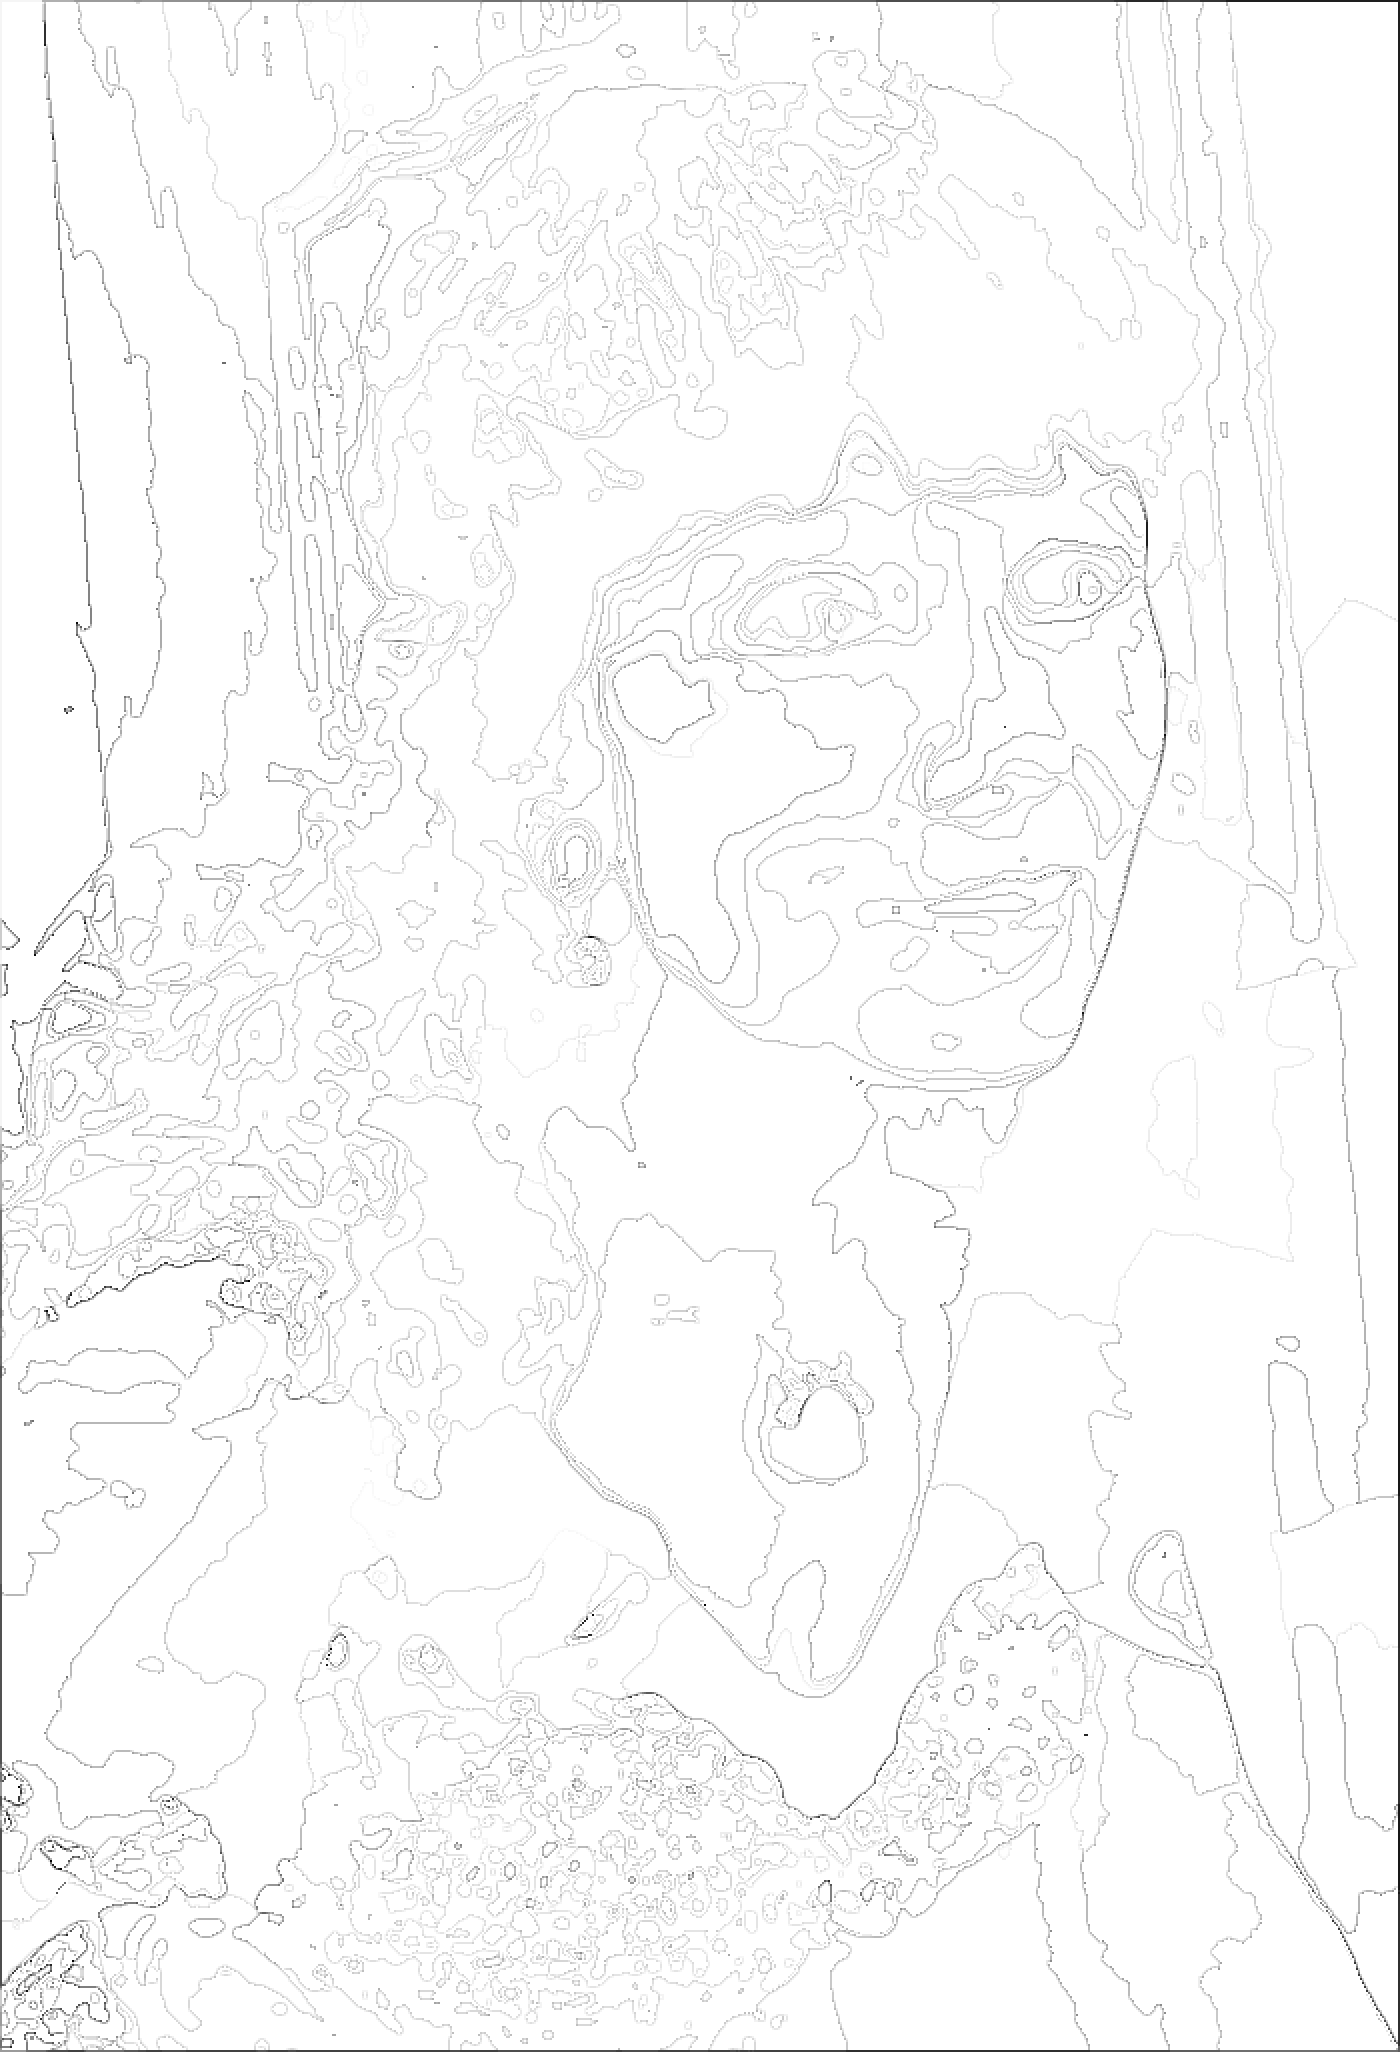

In [53]:
res_cont_u = enlarge(cont_u, factor=2)
res_u = enlarge(u, factor=2)
res_u.save(fname())
display(res_u)
res_cont_u.save(fname())
res_cont_u

### Наносим цифры на контурный рисунок. Выводим палитру

Filename: /home/aynur/Downloads/A1--4/21.png
Filename: /home/aynur/Downloads/A1--4/22.png


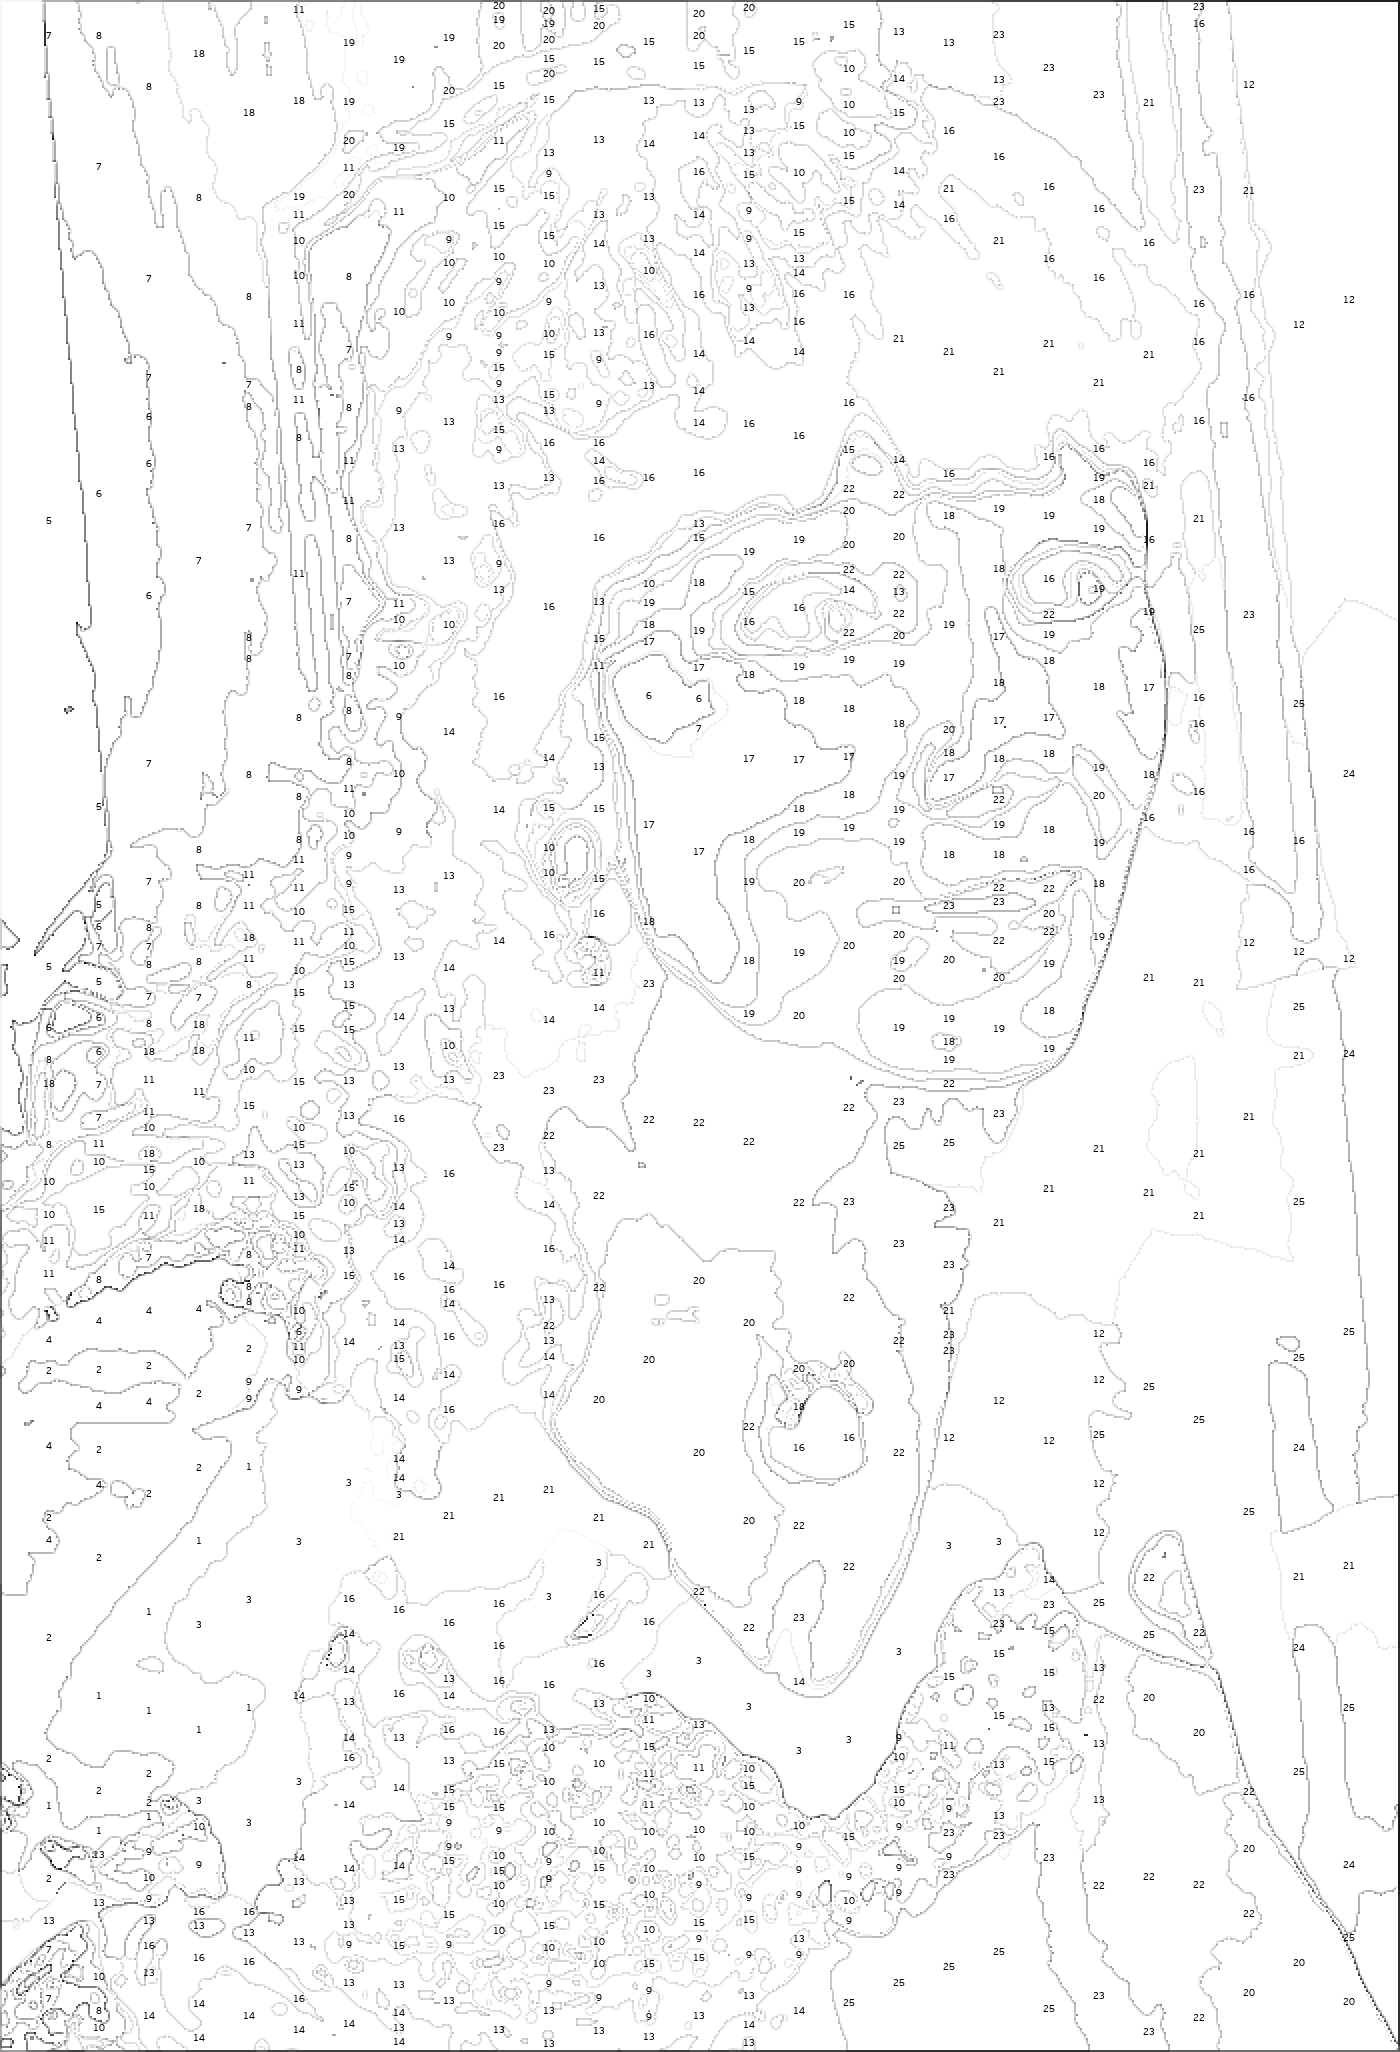

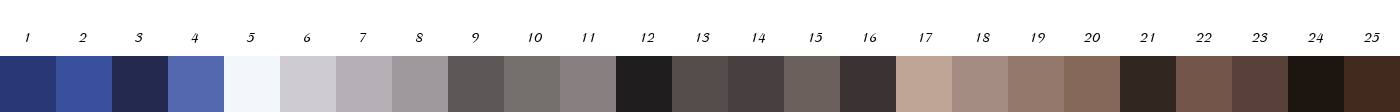

In [54]:
numb_pic, palette = mark_contour(res_u, res_cont_u, lim=10, font_size=10, grid_size=50)
numb_pic.save(fname())
palette.save(fname())

display(numb_pic, palette)